In [1]:
import numpy as np
import matplotlib.pyplot as plt
import Template
from pde import CartesianGrid, solve_laplace_equation
from scipy.sparse import diags, eye
from scipy.sparse.linalg import spsolve
Template = Template.Template()

## Laplace's equation
Laplace's equation is a second-order partial differential equation, commonly written as $(\nabla ^{2}f=0)$, which states that the sum of the second-order partial derivatives of a function ($f$) with respect to its spatial variables equals zero. It is used to model steady-state physical systems, meaning situations where things are not changing over time. This includes applications like electrostatics, heat conduction, fluid flow, and gravitation. Functions that satisfy Laplace's equation are called harmonic functions.

### Solution with py_pde


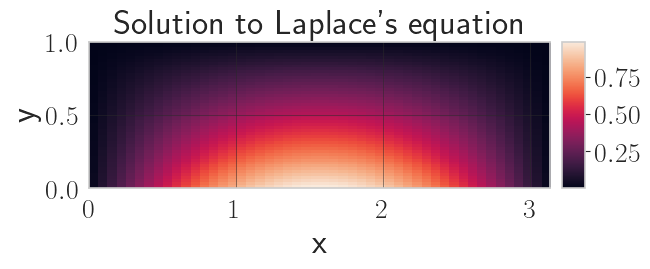

In [2]:
# Create grid: [0, π] x [0, 1]
grid = CartesianGrid([[0, np.pi], [0, 1]], [50, 50])

# Boundary conditions: u(x,0)=sin(x), u(x,1)=0, u(0,y)=0, u(1,y)=0
bcs = {
    "x": {"value": 0},        # x=0 and x=π: u=0
    "y-": {"value": "sin(x)"}, # y=0: u=sin(x)
    "y+": {"value": 0}         # y=1: u=0
}

# Solve Laplace equation
res = solve_laplace_equation(grid, bcs)
# Plot result
res.plot()

### Solution with finite differences 

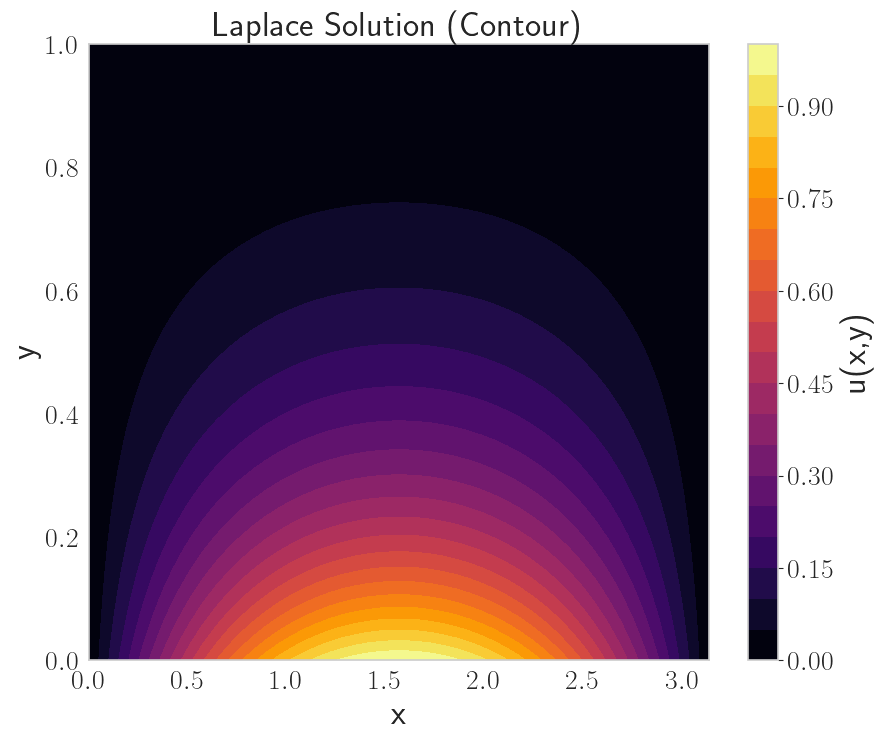

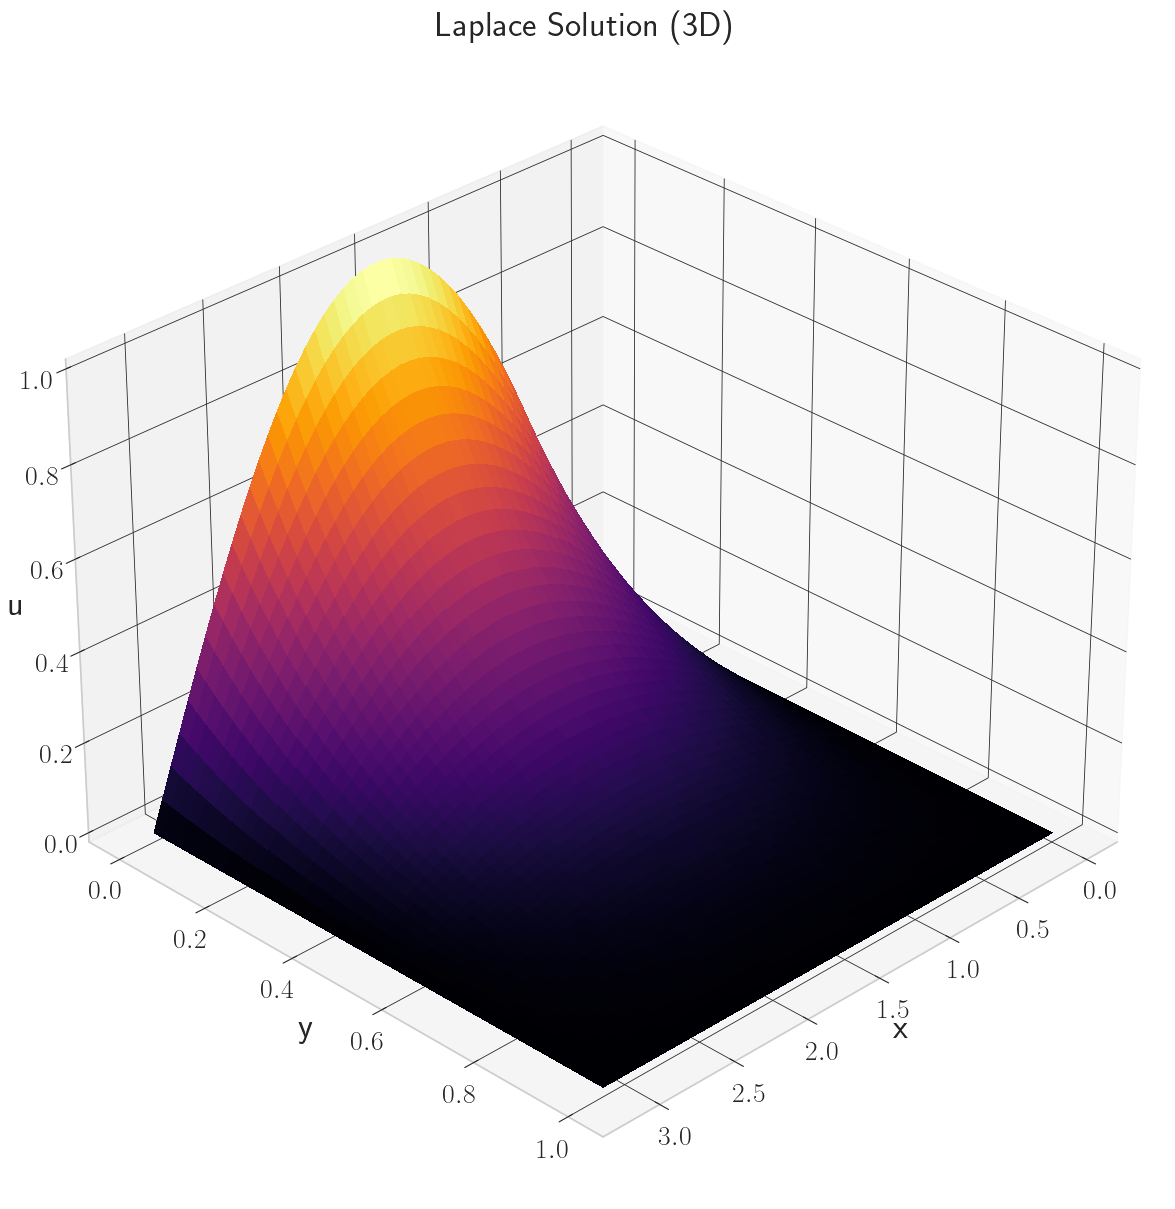

In [3]:
# Solved using finite differences on a 2D grid

def solve_laplace_2d(nx=50, ny=50, max_iter=1000, tol=1e-5):
    # Initialize grid
    u = np.zeros((nx, ny))
    
    # Boundary conditions: u(x,0)=sin(x), u(x,1)=0, u(0,y)=0, u(1,y)=0
    x = np.linspace(0, np.pi, nx)
    u[:, 0] = np.sin(x)  # Bottom boundary
    
    # Iterative solver (Relaxation)
    for iteration in range(max_iter):
        u_old = u.copy()
        
        # Central difference: u[i,j] = (u[i+1,j] + u[i-1,j] + u[i,j+1] + u[i,j-1]) / 4
        u[1:-1, 1:-1] = 0.25 * (u_old[2:, 1:-1] + u_old[:-2, 1:-1] + 
                                 u_old[1:-1, 2:] + u_old[1:-1, :-2])
        
        # Check convergence
        if np.max(np.abs(u - u_old)) < tol:
            print(f"Converged in {iteration} iterations")
            break
    
    return u, x, np.linspace(0, 1, ny)

# Solve and visualize
u, x, y = solve_laplace_2d()

plt.figure(figsize=(10, 8))
plt.contourf(x, y, u.T, levels=20, cmap='inferno')
plt.colorbar(label='u(x,y)')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Laplace Solution (Contour)')
plt.show()

plt.figure(figsize=(20, 15))
X, Y = np.meshgrid(x, y)
ax = plt.axes(projection='3d')
ax.view_init(elev=30, azim=45)
ax.plot_surface(X, Y, u.T, cmap='inferno', edgecolor='none', antialiased=False)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('u')
ax.set_title('Laplace Solution (3D)')
plt.show()

## Heat equation

The heat equation is a fundamental parabolic partial differential equation that describes how the distribution of heat (or variation in temperature) in a given region changes over time due to diffusion
The general form of the heat equation in a homogeneous and isotropic medium for a temperature function $u$ (which depends on spatial variables $(x,y,z)$ and time $t$) is: 
$$\frac{\partial u}{\partial t}=\alpha \nabla ^{2}u$$

### Backward-Difference Method

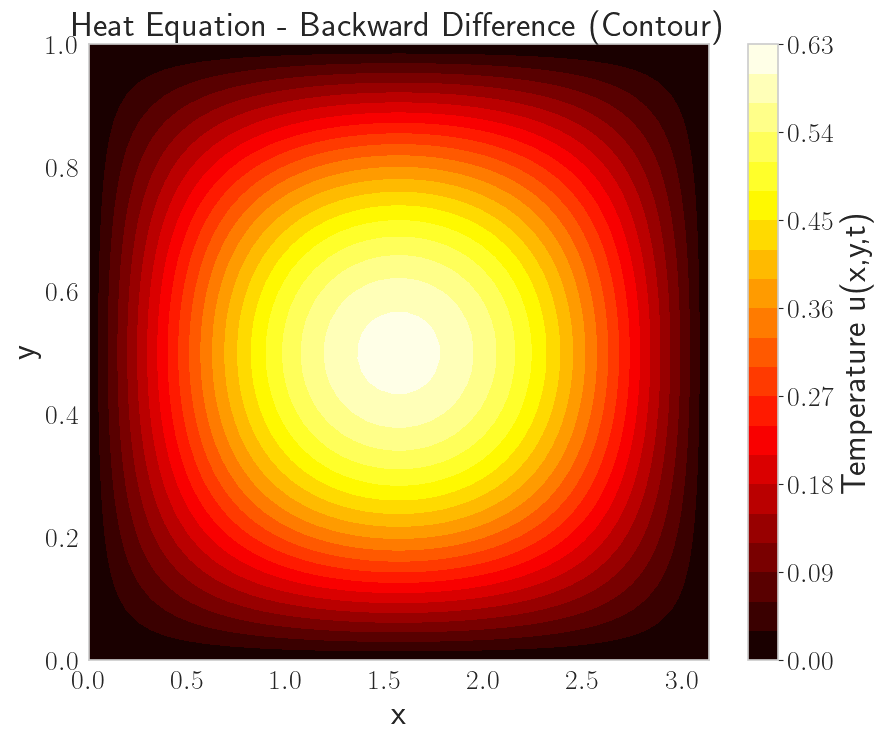

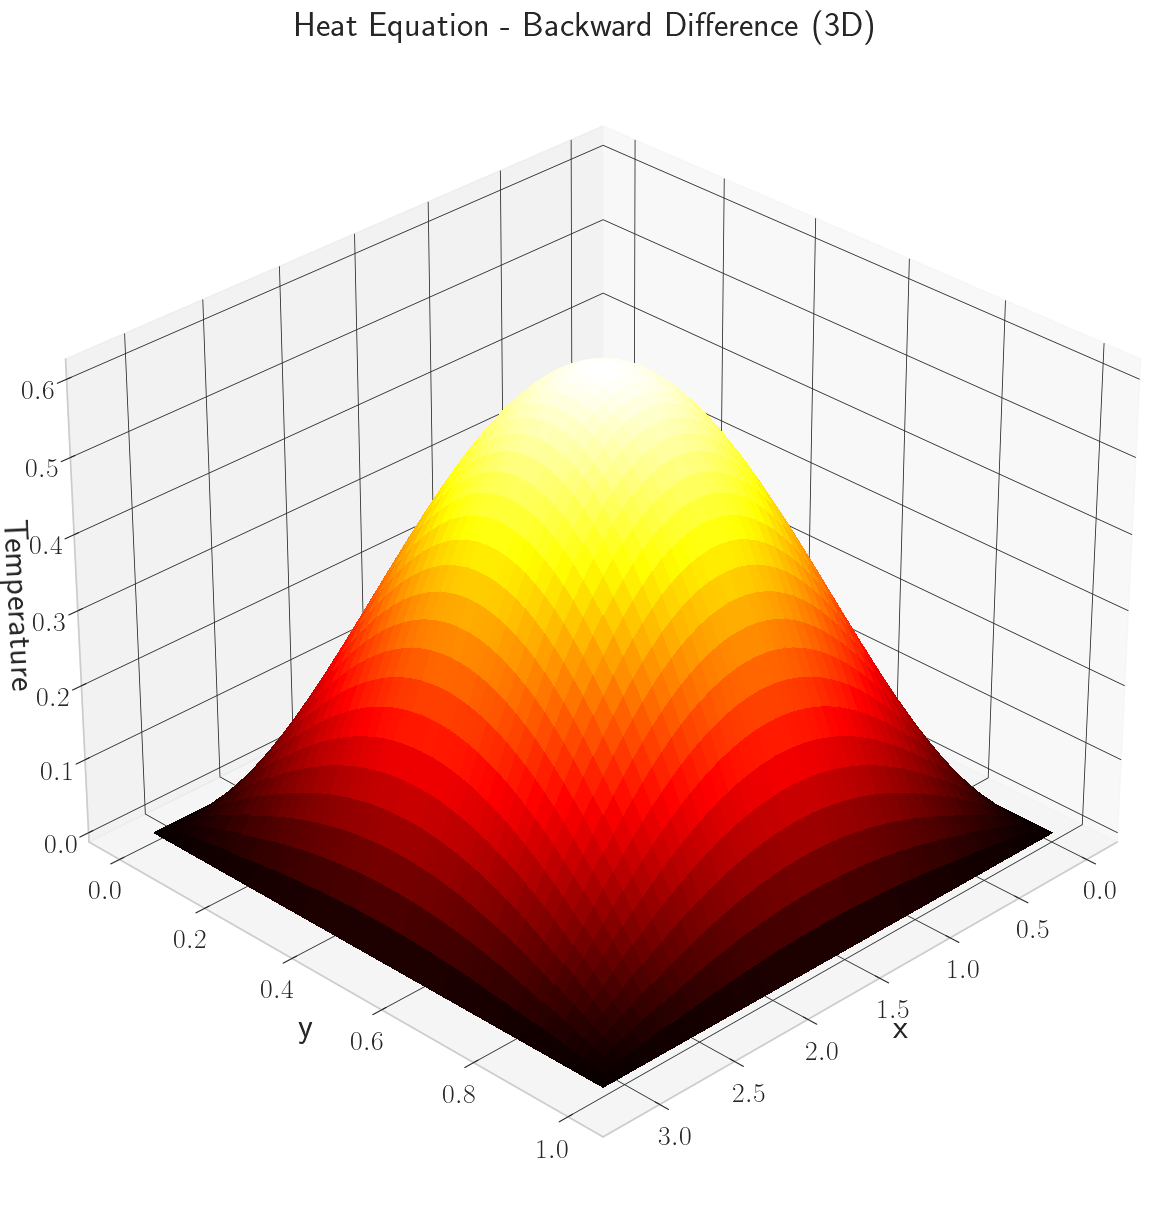

In [4]:
# Heat equation: ∂u/∂t = α∇²u = α(∂²u/∂x² + ∂²u/∂y²)
# Backward Difference Method: implicit in time, central in space (BTCS)

def solve_heat_backward(nx=50, ny=50, nt=500, alpha=0.01):
    
    # Grid parameters
    dx = np.pi / (nx - 1)
    dy = 1.0 / (ny - 1)
    dt = 0.5 * min(dx**2, dy**2) / alpha  # More stable than forward
    
    # Initialize grid
    u = np.zeros((nx, ny))
    
    # Initial condition: u(x,y,0) = sin(x)
    x = np.linspace(0, np.pi, nx)
    y = np.linspace(0, 1, ny)
    for i in range(nx):
        u[i, :] = np.sin(x[i])
    
    # Coefficients for implicit scheme
    rx = alpha * dt / dx**2
    ry = alpha * dt / dy**2
    
    # Time stepping using backward difference
    # u^(n+1) - α*dt*∇²u^(n+1) = u^n
    for n in range(nt):
        u_old = u.copy()
        
        # Solve implicitly for each interior point
        for i in range(1, nx-1):
            for j in range(1, ny-1):
                # Backward time: (1 + 2α*dt/dx² + 2α*dt/dy²)u[i,j]^(n+1) 
                # - α*dt/dx²(u[i+1,j]^(n+1) + u[i-1,j]^(n+1))
                # - α*dt/dy²(u[i,j+1]^(n+1) + u[i,j-1]^(n+1)) = u[i,j]^n
                
                # Using Gauss-Seidel iteration for simplicity
                u[i, j] = (u_old[i, j] + rx * (u[i+1, j] + u[i-1, j]) + 
                          ry * (u[i, j+1] + u[i, j-1])) / (1 + 2*rx + 2*ry)
        
        # Boundary conditions: u(0,y)=0, u(π,y)=0, u(x,0)=0, u(x,1)=0
        u[0, :] = 0
        u[-1, :] = 0
        u[:, 0] = 0
        u[:, -1] = 0
    
    return u, x, y

# Solve and visualize
u, x, y = solve_heat_backward()

plt.figure(figsize=(10, 8))
plt.contourf(x, y, u.T, levels=20, cmap='hot')
plt.colorbar(label='Temperature u(x,y,t)')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Heat Equation - Backward Difference (Contour)')
plt.show()

plt.figure(figsize=(20, 15))
X, Y = np.meshgrid(x, y)
ax = plt.axes(projection='3d')
ax.view_init(elev=30, azim=45)
ax.plot_surface(X, Y, u.T, cmap='hot', edgecolor='none', antialiased=False)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('Temperature')
ax.set_title('Heat Equation - Backward Difference (3D)')
plt.show()

### Forward difference method
The forward difference method is explained in chapter 12.2 of "Numerical Analysis" by Burden and Faires.

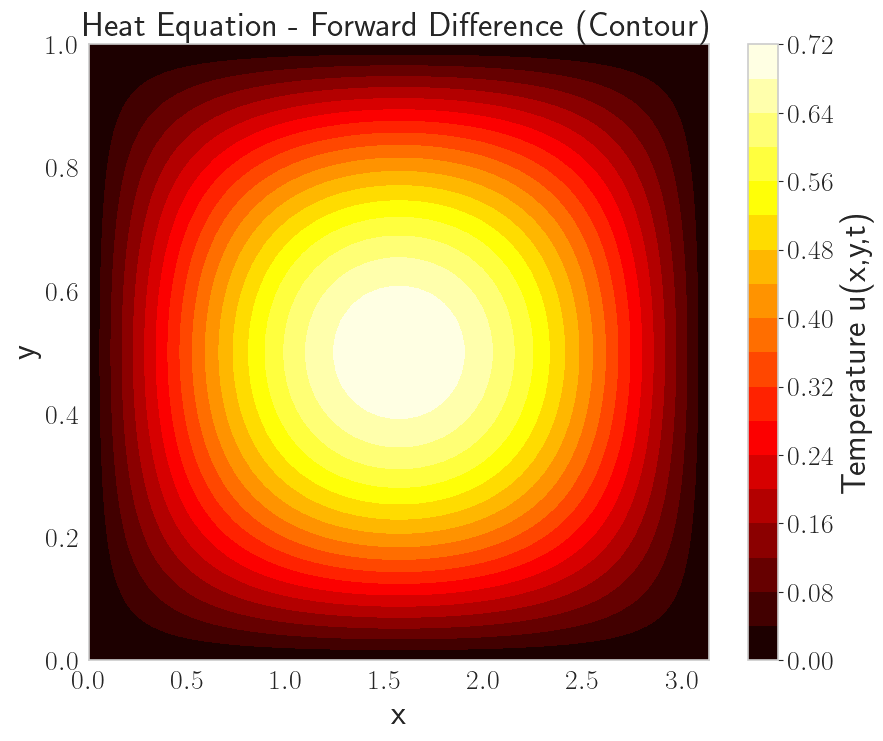

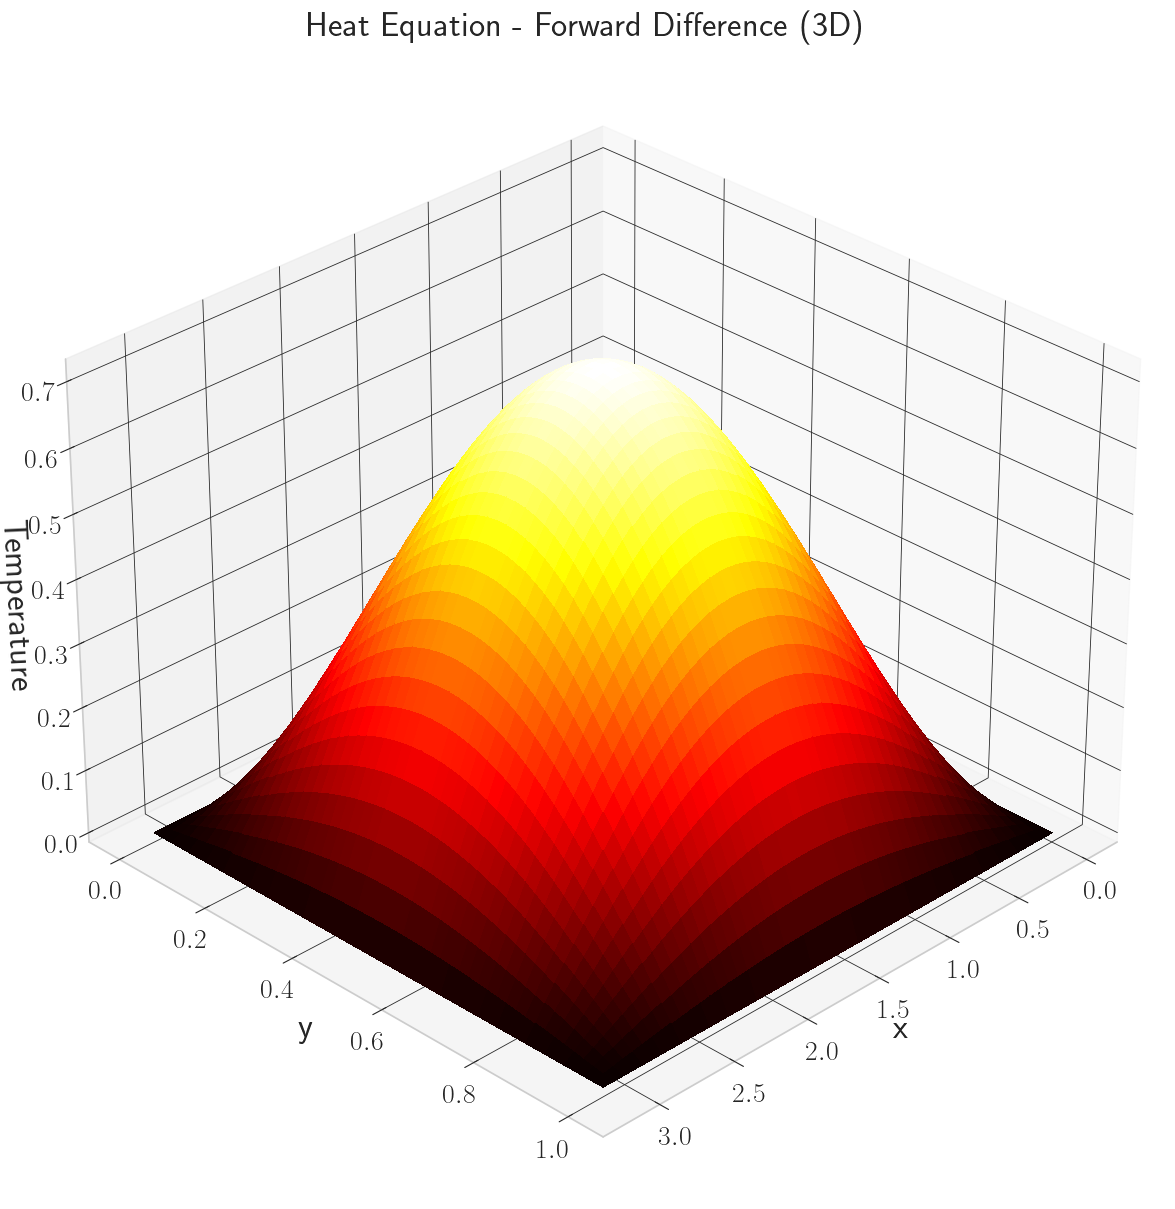

In [5]:
# Heat equation: ∂u/∂t = α∇²u
# Forward Difference Method: forward in time, central in space (FTCS)

def solve_heat_forward(nx=50, ny=50, nt=500, alpha=0.01):
    # Grid parameters
    dx = np.pi / (nx - 1)
    dy = 1.0 / (ny - 1)
    dt = 0.25 * min(dx**2, dy**2) / alpha  # CFL stability: dt ≤ 1/(4α) * min(dx², dy²)
    
    # Initialize grid
    u = np.zeros((nx, ny))
    
    # Initial condition: u(x,y,0) = sin(x)
    x = np.linspace(0, np.pi, nx)
    y = np.linspace(0, 1, ny)
    for i in range(nx):
        u[i, :] = np.sin(x[i])
    
    # Time stepping using forward difference
    for n in range(nt):
        u_new = u.copy()
        
        # Forward time: u^(n+1) = u^n + α*dt*∇²u^n
        # Central space: ∇²u = (u[i+1,j] - 2u[i,j] + u[i-1,j])/dx² + (u[i,j+1] - 2u[i,j] + u[i,j-1])/dy²
        for i in range(1, nx-1):
            for j in range(1, ny-1):
                u_new[i, j] = u[i, j] + alpha * dt * (
                    (u[i+1, j] - 2*u[i, j] + u[i-1, j]) / dx**2 +
                    (u[i, j+1] - 2*u[i, j] + u[i, j-1]) / dy**2
                )
        
        u = u_new
        
        # Boundary conditions: u(0,y)=0, u(π,y)=0, u(x,0)=0, u(x,1)=0
        u[0, :] = 0
        u[-1, :] = 0
        u[:, 0] = 0
        u[:, -1] = 0
    
    return u, x, y

# Solve and visualize
u, x, y = solve_heat_forward()

plt.figure(figsize=(10, 8))
plt.contourf(x, y, u.T, levels=20, cmap='hot')
plt.colorbar(label='Temperature u(x,y,t)')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Heat Equation - Forward Difference (Contour)')
plt.show()

plt.figure(figsize=(20, 15))
X, Y = np.meshgrid(x, y)
ax = plt.axes(projection='3d')
ax.view_init(elev=30, azim=45)
ax.plot_surface(X, Y, u.T, cmap='hot', edgecolor='none', antialiased=False)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('Temperature')
ax.set_title('Heat Equation - Forward Difference (3D)')
plt.show()

### Crank-Nicolson Method

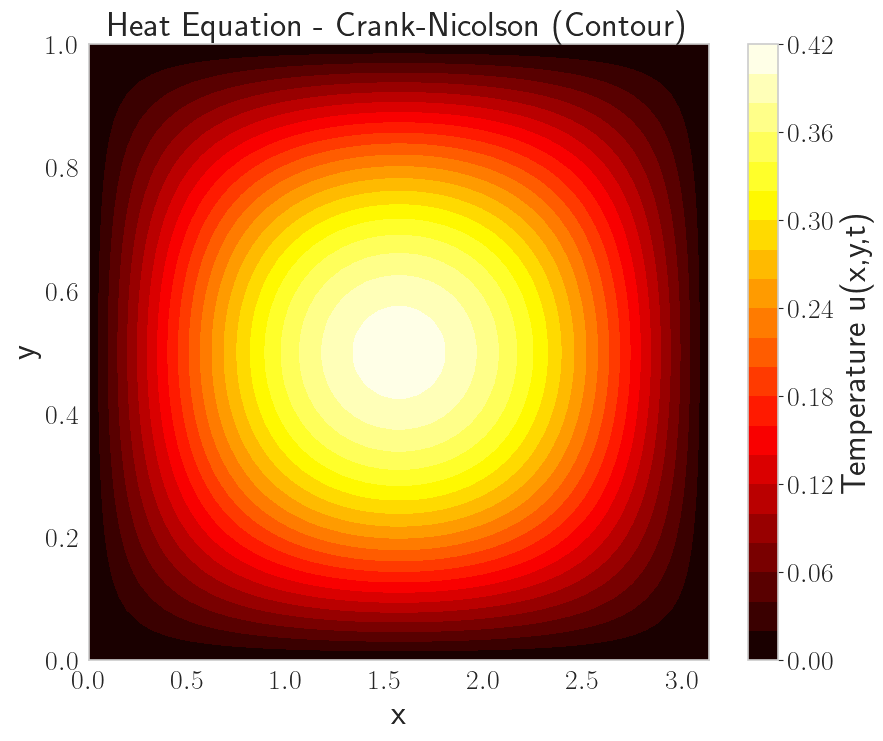

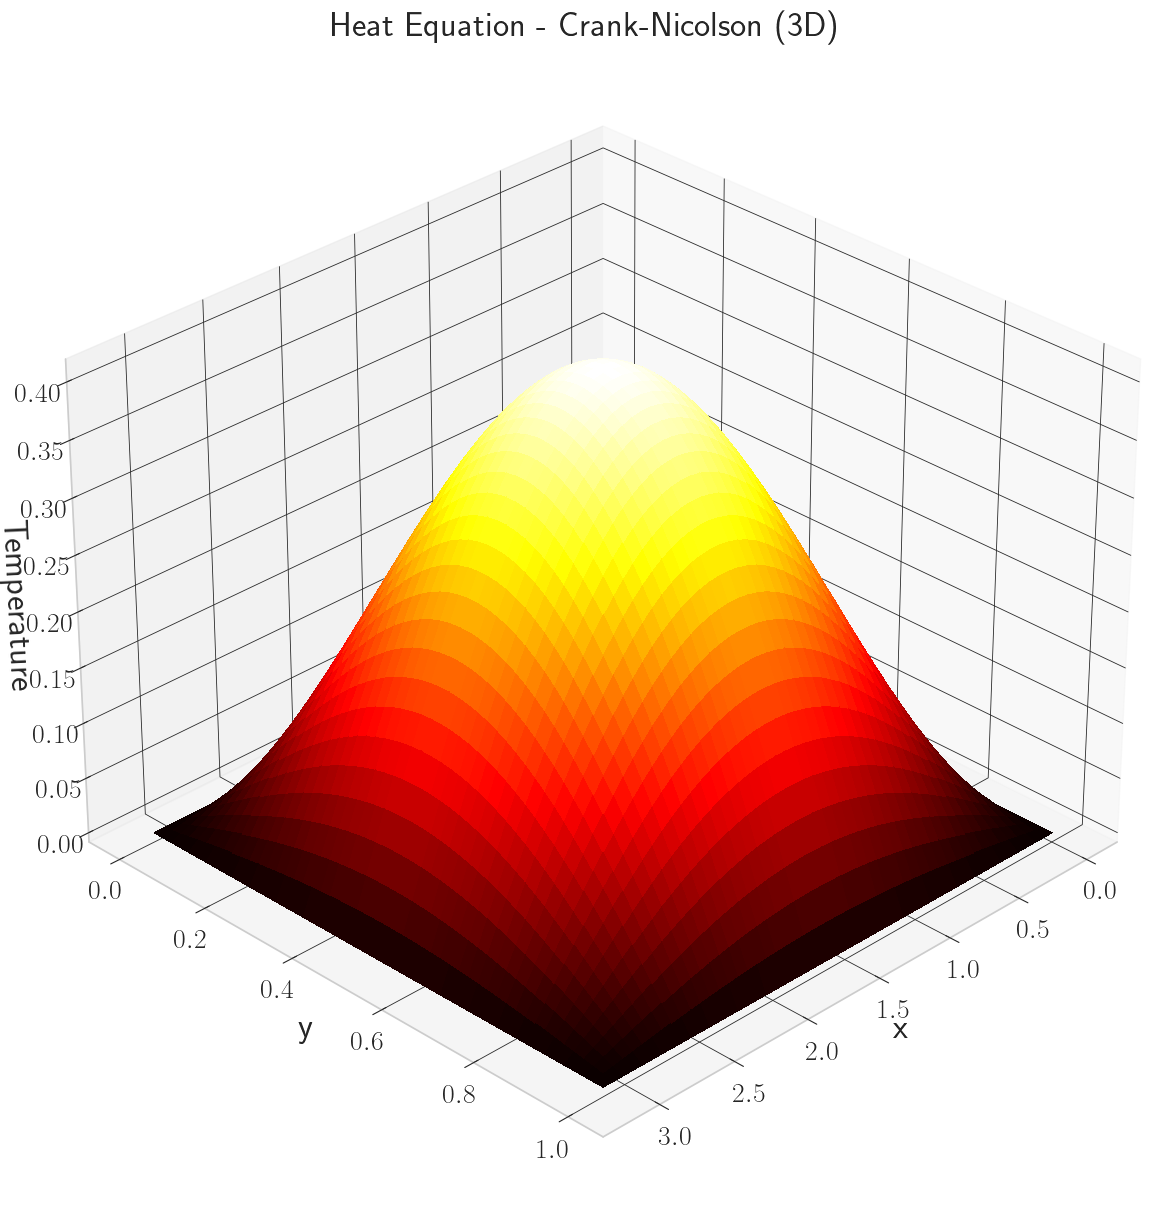

In [6]:
# Heat equation: ∂u/∂t = α∇²u
# Crank-Nicolson Method: implicit, central in space and time (average of forward and backward)

def solve_heat_crank_nicolson(nx=50, ny=50, nt=500, alpha=0.01):
    # Grid parameters
    dx = np.pi / (nx - 1)
    dy = 1.0 / (ny - 1)
    dt = 0.5 * min(dx**2, dy**2) / alpha  
    
    # Initialize grid
    u = np.zeros((nx, ny))
    
    # Initial condition: u(x,y,0) = sin(x)
    x = np.linspace(0, np.pi, nx)
    y = np.linspace(0, 1, ny)
    for i in range(nx):
        u[i, :] = np.sin(x[i])
    
    # Coefficients
    rx = alpha * dt / (2 * dx**2)
    ry = alpha * dt / (2 * dy**2)
    
    # Time stepping: (I + 0.5*α*dt*∇²)u^(n+1) = (I - 0.5*α*dt*∇²)u^n
    for n in range(nt):
        u_old = u.copy()
        
        # Solve implicitly using Gauss-Seidel
        for iteration in range(10):  # Inner iterations for convergence
            for i in range(1, nx-1):
                for j in range(1, ny-1):
                    # Right-hand side: explicit part
                    rhs = u_old[i, j] + rx * (u_old[i+1, j] - 2*u_old[i, j] + u_old[i-1, j]) + \
                          ry * (u_old[i, j+1] - 2*u_old[i, j] + u_old[i, j-1])
                    
                    # Left-hand side: implicit part
                    u[i, j] = (rhs + rx * (u[i+1, j] + u[i-1, j]) + 
                              ry * (u[i, j+1] + u[i, j-1])) / (1 + 2*rx + 2*ry)
        
        # Boundary conditions: u(0,y)=0, u(π,y)=0, u(x,0)=0, u(x,1)=0
        u[0, :] = 0
        u[-1, :] = 0
        u[:, 0] = 0
        u[:, -1] = 0
    
    return u, x, y

# Solve and visualize
u, x, y = solve_heat_crank_nicolson()

plt.figure(figsize=(10, 8))
plt.contourf(x, y, u.T, levels=20, cmap='hot')
plt.colorbar(label='Temperature u(x,y,t)')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Heat Equation - Crank-Nicolson (Contour)')
plt.show()

plt.figure(figsize=(20, 15))
X, Y = np.meshgrid(x, y)
ax = plt.axes(projection='3d')
ax.view_init(elev=30, azim=45)
ax.plot_surface(X, Y, u.T, cmap='hot', edgecolor='none', antialiased=False)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('Temperature')
ax.set_title('Heat Equation - Crank-Nicolson (3D)')
plt.show()

## Wave equation

The **wave equation** is a fundamental second-order partial differential equation (PDE) that describes how waves propagate through space and time. It's the mathematical basis for understanding phenomena like sound waves, light waves, and vibrations on a string.

**1D Wave Equation**

In its simplest, one-dimensional form, the equation is:

$$
\frac{\partial^2 u}{\partial t^2} = c^2 \frac{\partial^2 u}{\partial x^2}
$$

Essentially, the equation states that the acceleration of the wave at any point is directly proportional to its curvature at that same point.

### Finite Element Method

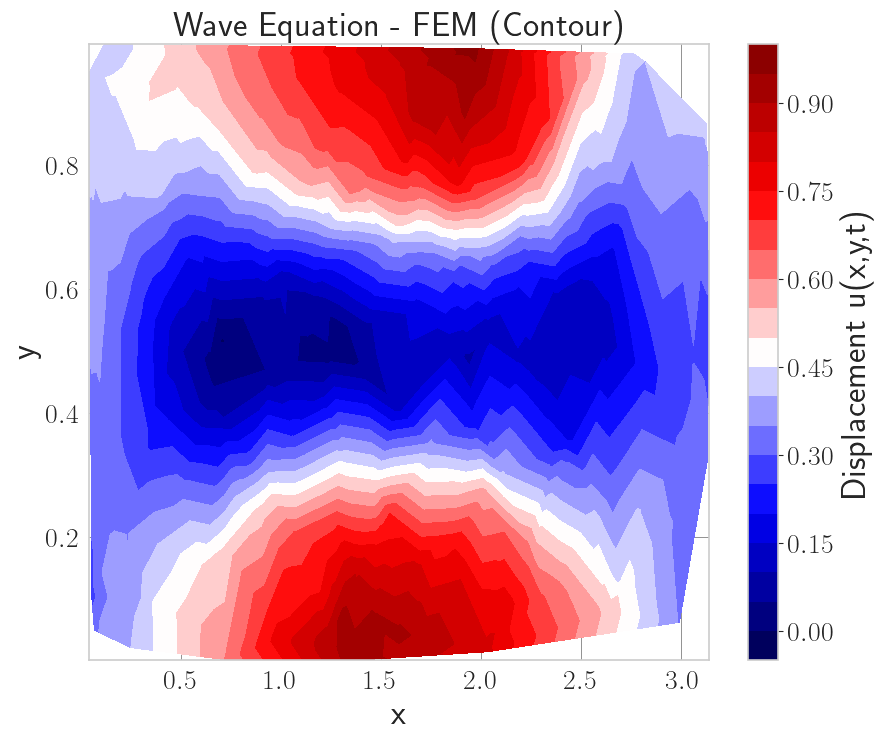

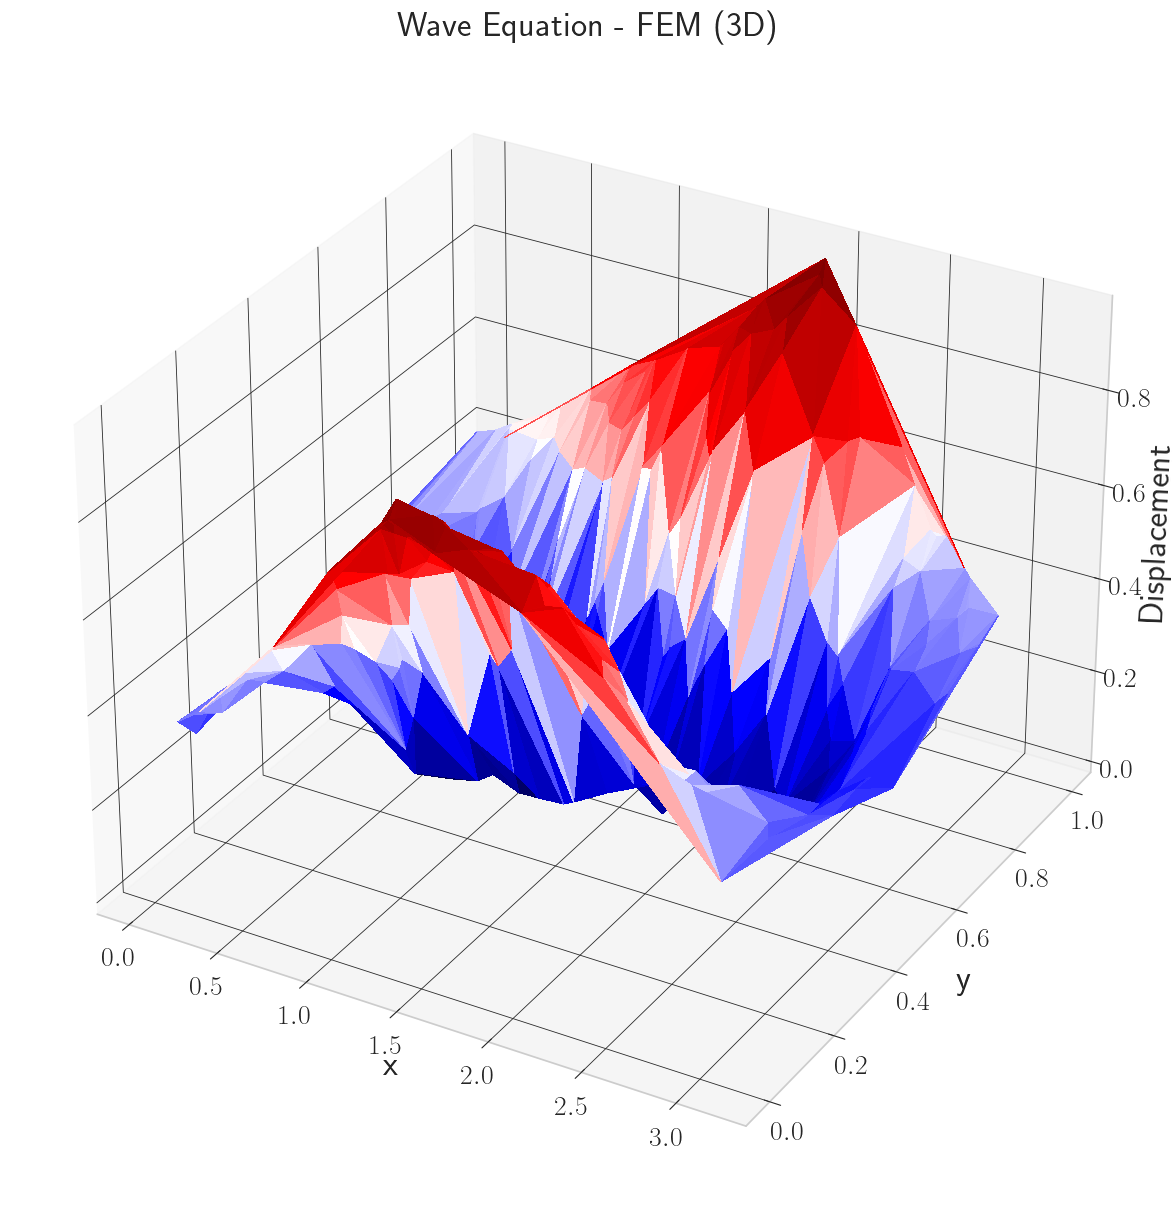

In [7]:
# Wave equation: ∂²u/∂t² = c²∇²u
# Finite Element Method (FEM) with triangular elements

from scipy.spatial import Delaunay
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve

def solve_wave_fem(n_points=300, nt=500, c=1.0):
    # Generate mesh points on [0,π] x [0,1]
    x_coords = np.random.uniform(0, np.pi, n_points)
    y_coords = np.random.uniform(0, 1, n_points)
    points = np.column_stack([x_coords, y_coords])
    
    # Triangulation (mesh generation)
    tri = Delaunay(points)
    n_nodes = len(points)
    
    # Time parameters
    dt = 0.001
    
    # Initial condition: u(x,y,0) = sin(x)*sin(πy)
    u = np.sin(points[:, 0]) * np.sin(np.pi * points[:, 1])
    u_old = u.copy()
    v = np.zeros(n_nodes)  # ∂u/∂t(x,y,0) = 0
    
    # Assembly: Mass matrix M and Stiffness matrix K
    # Weak form: ∫φᵢ(∂²u/∂t²)dΩ = c²∫∇φᵢ·∇u dΩ
    # M(∂²u/∂t²) = -c²Ku
    M = lil_matrix((n_nodes, n_nodes))
    K = lil_matrix((n_nodes, n_nodes))
    
    for simplex in tri.simplices:
        # Element vertices
        vertices = points[simplex]
        x1, y1 = vertices[0]
        x2, y2 = vertices[1]
        x3, y3 = vertices[2]
        
        # Area of triangle
        area = 0.5 * abs((x2-x1)*(y3-y1) - (x3-x1)*(y2-y1))
        
        # Local mass matrix: Mₑ = (area/12)[2 1 1; 1 2 1; 1 1 2]
        for i in range(3):
            for j in range(3):
                M[simplex[i], simplex[j]] += area * (1 + (i==j)) / 12
        
        # Gradient matrix B: ∇φ = B
        B = np.array([
            [y2-y3, y3-y1, y1-y2],
            [x3-x2, x1-x3, x2-x1]
        ]) / (2*area)
        
        # Local stiffness matrix: Kₑ = area * BᵀB
        K_local = area * (B.T @ B)
        for i in range(3):
            for j in range(3):
                K[simplex[i], simplex[j]] += K_local[i, j]
    
    M = M.tocsr()
    K = K.tocsr()
    
    # Apply boundary conditions (fixed boundaries)
    boundary_nodes = np.where((points[:, 0] == 0) | (points[:, 0] == np.pi) | 
                               (points[:, 1] == 0) | (points[:, 1] == 1))[0]
    
    # Time integration: Newmark-β method
    # u^(n+1) = 2u^n - u^(n-1) + dt²M⁻¹(-c²Ku^n)
    for n in range(nt):
        # Acceleration: a = M⁻¹(-c²Ku)
        force = -c**2 * K @ u
        
        # Central difference: u^(n+1) = 2u^n - u^(n-1) + dt²a
        u_new = 2*u - u_old + dt**2 * spsolve(M, force)
        
        # Apply boundary conditions
        u_new[boundary_nodes] = 0
        
        u_old = u.copy()
        u = u_new
    
    return u, points, tri

# Solve
u, points, tri = solve_wave_fem()

# Visualize
plt.figure(figsize=(10, 8))
plt.tricontourf(points[:, 0], points[:, 1], u, levels=20, cmap='seismic')
plt.colorbar(label='Displacement u(x,y,t)')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Wave Equation - FEM (Contour)')
plt.show()

# 3D plot
fig = plt.figure(figsize=(20, 15))
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(points[:, 0], points[:, 1], u, cmap='seismic', edgecolor='none', antialiased=False)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('Displacement')
ax.set_title('Wave Equation - FEM (3D)')
plt.show()